# Exploratory Data Analysis (Formatted Zone)
Complex Seasonality Analysis

In [389]:
from database_settings import postgres_utilities
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

## Get the time series


In [390]:
# Establish the connection with the Persistent Zone
engine = postgres_utilities.engine()
# Filters
net_weight_threshold = 100
value_usd_threshold = 200
headings_count_threshold = 100
year_threshold = 2017
# Get all the data filtered
df = pd.DataFrame(postgres_utilities.run_query_file(engine,
                                           './queries/heading_data.sql',
                                           params={'year_threshold': year_threshold,
                                                   'headings_count_threshold': headings_count_threshold,
                                                   'value_usd_threshold': value_usd_threshold,
                                                   'net_weight_threshold': net_weight_threshold}))

Connected to Formatted Zone successfully!


In [391]:
# Select a random heading (optionally, select a exporter)
heading, description, exporter = df.sample()[['heading','description', 'exporter_id']].iloc[0]
print('Heading: {}, Description: {}'.format(heading,description))
heading_data = df[(df['heading']==heading)].copy()

Heading: 0806100000, Description: Uvas frescas


### Daily kilogram's price time series

In [392]:
# usd/kg time series
heading_data['usd_kg'] = heading_data['value_usd']/heading_data['net_weight']
heading_data['usd_kg'] = heading_data['usd_kg'].astype(float)
heading_data['usd_kg'] = heading_data['usd_kg'].round(3)
# Group by boarding_date
usd_kg = heading_data[['boarding_date','usd_kg']].groupby(by=['boarding_date']).mean().round(3)
# Impute missing dates assigning the usd_kg of the day before
usd_kg.index = pd.to_datetime(usd_kg.index)
usd_kg = usd_kg.resample('D').ffill()

### Daily total (net) weight exporter time series

In [393]:
# total net weight time series
# Group by boarding_date
net_weight = heading_data[['boarding_date','net_weight']].groupby(by=['boarding_date']).sum().round(3)
# Impute missing dates assigning 0 kg for days without shipments
net_weight.index = pd.to_datetime(net_weight.index)
net_weight = net_weight.resample('D').asfreq()
net_weight.fillna(0.0, inplace=True)
# Convert numerical columns to float
net_weight = net_weight.astype({'net_weight': 'float'})

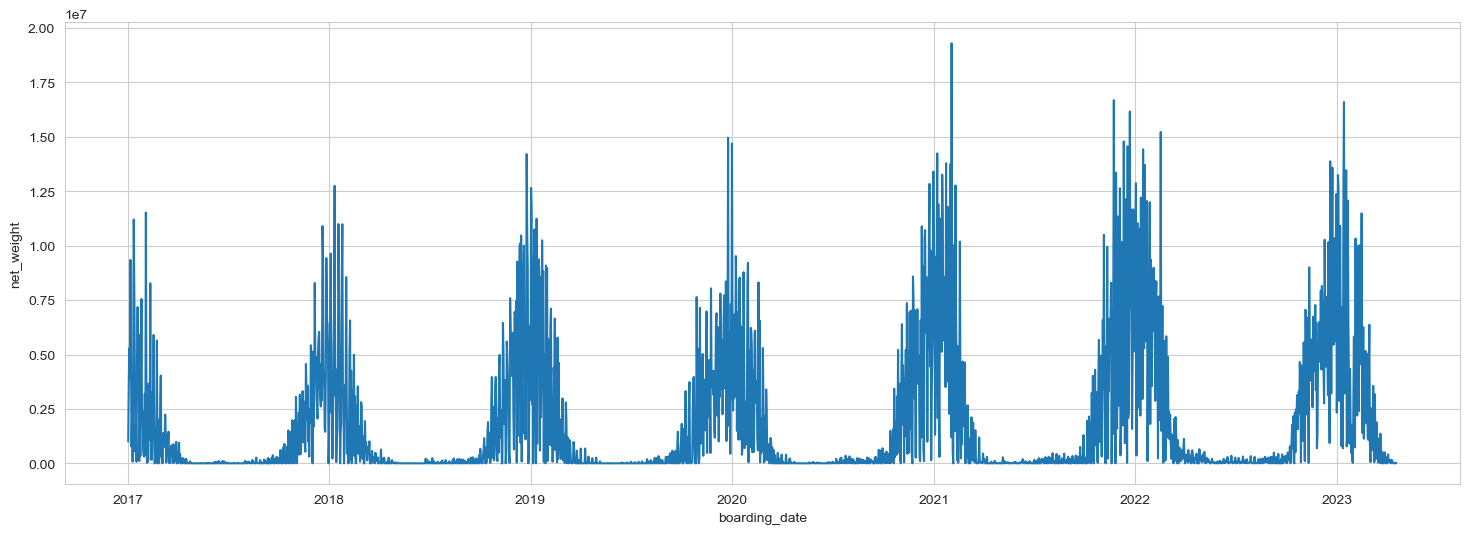

In [394]:
# Plot time series
plt.figure(figsize=(18,6))
sns.lineplot(x="boarding_date", y="net_weight", data=net_weight)
plt.show()

In [395]:
# # # Generate the cyclic time granularities
# import numpy as np
# #
# # # First get irregular periods for quasi-circular granularities
# net_weight['days_in_month'] = pd.PeriodIndex(net_weight.index, freq='M').end_time.day
# net_weight['days_in_year'] = pd.PeriodIndex(net_weight.index, freq='Y').end_time.dayofyear
# net_weight['weeks_in_month'] = np.ceil(pd.PeriodIndex(net_weight.index, freq='M').end_time.day/7).astype(np.int64)

In [396]:
# net_weight['day_in_month']= net_weight.index.day % net_weight['days_in_month']
# net_weight

In [418]:
import numpy as np
# Generate the cyclic time granularities

# Native constructions
net_weight['month_in_year'] = net_weight.index.month
net_weight['day_in_week'] = net_weight.index.day_of_week + 1
net_weight['day_in_month']= net_weight.index.day
net_weight['day_in_year'] =  net_weight.index.day_of_year
net_weight['week_in_year'] = net_weight.index.isocalendar().week

# Simple constructions
net_weight['semester_in_year']=np.ceil(net_weight['month_in_year']/6).astype(np.int64)
net_weight['quarter_in_year']=np.ceil(net_weight['month_in_year']/3).astype(np.int64)
net_weight['month_in_quarter'] = [(i%3 if i%3 > 0 else 3) for i in net_weight['month_in_year']]
net_weight['month_in_semester']= [(i%6 if i%6 > 0 else 6) for i in net_weight['month_in_year']]
net_weight['quarter_in_semester']= [(i%2 if i%2> 0 else 2) for i in net_weight['quarter_in_year']]

# Complex constructions
net_weight['week_in_month'] = [(i.isocalendar().week-i.replace(day=1).week+1 if i.month != 1 else i.isocalendar().week)  for i in net_weight.index.to_series()]
net_weight['week_in_semester'] = [(i.isocalendar().week-i.replace(month=6, day=30).week + (1 if datetime.date(i.isocalendar().year, 6, 30).isocalendar().week == datetime.date(i.isocalendar().year, 7, 1).isocalendar().week else 0) if i.month > 6 else i.isocalendar().week)  for i in net_weight.index.to_series()]
net_weight['week_in_quarter'] = [(i.isocalendar().week if i.month <= 3
                                    else i.isocalendar().week-i.replace(month=3, day=31).week
                                         + (1 if datetime.date(i.isocalendar().year, 3, 31).isocalendar().week == datetime.date(i.isocalendar().year, 4, 1).isocalendar().week else 0)
                                    if i.month <= 6
                                    else i.isocalendar().week-i.replace(month=6, day=30).week
                                         + (1 if datetime.date(i.isocalendar().year, 6, 30).isocalendar().week == datetime.date(i.isocalendar().year, 7, 1).isocalendar().week else 0)
                                    if i.month <= 9
                                    else i.isocalendar().week-i.replace(month=9, day=30).week
                                        + (1 if datetime.date(i.isocalendar().year, 9, 30).isocalendar().week == datetime.date(i.isocalendar().year, 10, 1).isocalendar().week else 0)
                                  ) for i in net_weight.index.to_series()]
net_weight['day_in_semester'] = [i.day_of_year-i.replace(month=6, day=30).day_of_year if i.month > 6 else i.day_of_year for i in net_weight.index.to_series()]
net_weight['day_in_quarter'] = [(i.day_of_year if i.month <= 3
                                else i.day_of_year-i.replace(month=3, day=31).day_of_year if i.month <= 6
                                else i.day_of_year-i.replace(month=6, day=30).day_of_year if i.month <= 9
                                else i.day_of_year-i.replace(month=9, day=30).day_of_year
                                  ) for i in net_weight.index.to_series()]

In [419]:
net_weight

,net_weight,month_in_year,week_in_year,week_in_semester,week_in_month,week_in_quarter,day_in_semester,day_in_quarter,day_in_week,day_in_month,day_in_year,semester_in_year,quarter_in_year,month_in_quarter,month_in_semester,quarter_in_semester
boarding_date,,,,,,,,,,,,,,,,
2017-01-02,1002933.70,1,1,1,1,1,2,2,1,2,2,1,1,1,1,1
2017-01-03,3696504.80,1,1,1,1,1,3,3,2,3,3,1,1,1,1,1
2017-01-04,5290304.46,1,1,1,1,1,4,4,3,4,4,1,1,1,1,1
2017-01-05,3915774.80,1,1,1,1,1,5,5,4,5,5,1,1,1,1,1
2017-01-06,9345361.64,1,1,1,1,1,6,6,5,6,6,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-15,33096.00,4,15,15,3,3,105,15,6,15,105,1,2,1,4,2
2023-04-16,0.00,4,15,15,3,3,106,16,7,16,106,1,2,1,4,2
2023-04-17,0.00,4,16,16,4,4,107,17,1,17,107,1,2,1,4,2


In [417]:
net_weight

,net_weight,month_in_year,week_in_year,week_in_semester,week_in_month,week_in_quarter,day_in_semester,day_in_quarter
boarding_date,,,,,,,,
2017-01-02,1002933.70,1,1,1,1,1,2,2
2017-01-03,3696504.80,1,1,1,1,1,3,3
2017-01-04,5290304.46,1,1,1,1,1,4,4
2017-01-05,3915774.80,1,1,1,1,1,5,5
2017-01-06,9345361.64,1,1,1,1,1,6,6
...,...,...,...,...,...,...,...,...
2023-04-15,33096.00,4,15,15,3,3,105,15
2023-04-16,0.00,4,15,15,3,3,106,16
2023-04-17,0.00,4,16,16,4,4,107,17


In [339]:
net_weight

,net_weight,month_in_year,day_in_week,day_in_month,day_in_year,week_in_year
boarding_date,,,,,,
2017-01-06,42528.000,1,5,6,6,1
2017-01-07,63552.000,1,6,7,7,1
2017-01-08,0.000,1,7,8,8,1
2017-01-09,0.000,1,1,9,9,2
2017-01-10,0.000,1,2,10,10,2
...,...,...,...,...,...,...
2023-04-16,600315.908,4,7,16,106,15
2023-04-17,350980.360,4,1,17,107,16
2023-04-18,164508.000,4,2,18,108,16


In [198]:
(net_weight.index - pd.offsets.MonthEnd(1)).isocalendar().week

TypeError: unsupported operand type(s) for -: 'numpy.ndarray' and 'pandas._libs.tslibs.offsets.MonthEnd'

In [ ]:
(net_weight.index - pd.offsets.MonthEnd(1)).isocalendar().week.values

In [ ]:
temp = (net_weight['day_in_year']-net_weight['day_in_month']).to_list()




In [ ]:
import numpy as np
# Generate the cyclic time granularities
net_weight['day_in_month']= net_weight.index.day
net_weight['day_in_quarter']= net_weight.index.dayofyear - pd.PeriodIndex(net_weight.index, freq='Q').start_time.dayofyear + 1
net_weight['day_in_semester']= net_weight.index.dayofyear - net_weight.index.map(lambda x: pd.Timestamp(year=x.year, month=1 if x.month <= 6 else 7, day=1)).dayofyear + 1
net_weight['day_in_year'] = net_weight.index.dayofyear
net_weight['week_in_fortnight'] = [np.ceil((i%14+1)/7).astype(int) for i in range(0, len(net_weight))]
net_weight['week_in_month'] =  np.ceil(net_weight.index.day/7).astype(np.int64)
net_weight['week_in_quarter'] = net_weight.index.isocalendar().week - pd.PeriodIndex(net_weight.index, freq='Q').start_time.week + 1

In [ ]:
net_weight

In [ ]:
# Seasonal plot (yearly)
plt.figure(figsize=(18,6))
sns.lineplot(x=pd.to_datetime(net_weight['boarding_date']).dt.week,
            y=net_weight['net_weight'],
            legend='full',
            palette=sns.color_palette("dark:salmon_r", as_cmap=True),
            errorbar=None)
plt.legend(bbox_to_anchor=(1, 1), loc=2);
plt.show()

In [ ]:
sns.boxplot(x=pd.to_datetime(net_weight['boarding_date']).dt.day,
            y=net_weight['net_weight'],
            hue=pd.to_datetime(net_weight['boarding_date']).dt.month)
plt.show()